<a href="https://colab.research.google.com/github/michalinabijak/ERC/blob/main/Dialoguegcn_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install torch_geometric
! pip install torch_sparse
! pip install torch_scatter

     |████████████████████████████████| 222 kB 8.6 MB/s 
     |████████████████████████████████| 376 kB 15.4 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388142 sha256=c830a2a27c66a7dcfc11f108bb9439ff75b933548c036026a2f4b067a85b0fbc
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric
     |████████████████████████████████| 40 kB 3.8 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.11-cp37-cp37m-linux_x86_64.whl size=444203 sha256=ef72ab37f75a5d044e7cbe997b8c807d1f077662f47e2cee3bdb37d0236f2bbd
  Stored in directory: /root/.cache/pip/wheels/72/96/50/6d96633dcb6fa6afd1b210a4cdeb1fa30a400c352b88732a1f
Successfully built torch-sparse
  Created wheel for torch-scatter: filename=torch_scatter-2.0.8-cp37-cp37m-linux_x86_64.whl size=281098 sha256=33dbcf1270a22954000bee5d5fc262f9cead2

In [ ]:
import sys
import os

py_file_location = "/content/drive/MyDrive/DialogueGCN-mianzhang/dgcn"

In [ ]:
sys.path.append(os.path.abspath(py_file_location))

## GET DATA

In [ ]:
import argparse

from tqdm import tqdm
import pickle

import utils
from Sample import Sample

log = utils.get_logger()


def split():
    utils.set_seed(100)

    video_ids, video_speakers, video_labels, video_text, \
        video_audio, video_visual, video_sentence, trainVids, \
        test_vids = pickle.load(open('/content/drive/MyDrive/DialogueGCN-mianzhang/IEMOCAP_features.pkl', 'rb'), encoding='latin1')

    train, dev, test = [], [], []
    dev_size = int(len(trainVids) * 0.1)
    train_vids, dev_vids = trainVids[dev_size:], trainVids[:dev_size]

    for vid in tqdm(train_vids, desc="train"):
        train.append(Sample(vid, video_speakers[vid], video_labels[vid],
                                 video_text[vid], video_audio[vid], video_visual[vid],
                                 video_sentence[vid]))
    for vid in tqdm(dev_vids, desc="dev"):
        dev.append(Sample(vid, video_speakers[vid], video_labels[vid],
                               video_text[vid], video_audio[vid], video_visual[vid],
                               video_sentence[vid]))
    for vid in tqdm(test_vids, desc="test"):
        test.append(Sample(vid, video_speakers[vid], video_labels[vid],
                                video_text[vid], video_audio[vid], video_visual[vid],
                                video_sentence[vid]))
    log.info("train vids:")
    log.info(sorted(train_vids))
    log.info("dev vids:")
    log.info(sorted(dev_vids))
    log.info("test vids:")
    log.info(sorted(test_vids))

    return train, dev, test


In [ ]:
train, dev, test = split()
data = {"train": train, "dev": dev, "test": test}
with open('/content/drive/MyDrive/DialogueGCN-mianzhang/data_split.pickle', 'wb') as handle:
    pickle.dump(data, handle)

test: 100%|██████████| 31/31 [00:00<00:00, 10398.55it/s]

08/04/2021 02:13:50 train vids:
08/04/2021 02:13:50 ['Ses01F_impro01', 'Ses01F_impro02', 'Ses01F_impro03', 'Ses01F_impro04', 'Ses01F_impro05', 'Ses01F_impro06', 'Ses01F_impro07', 'Ses01F_script01_1', 'Ses01F_script01_2', 'Ses01F_script01_3', 'Ses01F_script02_1', 'Ses01F_script02_2', 'Ses01F_script03_1', 'Ses01F_script03_2', 'Ses01M_impro01', 'Ses01M_impro02', 'Ses01M_impro04', 'Ses01M_impro05', 'Ses01M_impro06', 'Ses01M_impro07', 'Ses01M_script01_1', 'Ses01M_script01_2', 'Ses01M_script01_3', 'Ses01M_script02_1', 'Ses01M_script03_1', 'Ses01M_script03_2', 'Ses02F_impro01', 'Ses02F_impro02', 'Ses02F_impro03', 'Ses02F_impro04', 'Ses02F_impro05', 'Ses02F_impro06', 'Ses02F_impro07', 'Ses02F_impro08', 'Ses02F_script01_2', 'Ses02F_script02_1', 'Ses02F_script02_2', 'Ses02F_script03_1', 'Ses02F_script03_2', 'Ses02M_impro01', 'Ses02M_impro03', 'Ses02M_impro04', 'Ses02M_impro05', 'Ses02M_impro06', 'Ses02M_script01_1', 'Ses02M_script01_2', 'Ses02M_script01_3', 'Ses02M_script02_1', 'Ses02M_script03_

# HELPERS

In [ ]:
import math
import random
class Dataset:

    def __init__(self, samples, batch_size, multim=False):
        self.samples = samples
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(self.samples) / batch_size)
        self.speaker_to_idx = {'M': 0, 'F': 1}
        self.multim = multim
        self.size = 712 if multim else 100

    def __len__(self):
        return self.num_batches

    def __getitem__(self, index):
        batch = self.raw_batch(index)
        return self.padding(batch)

    def raw_batch(self, index):
        assert index < self.num_batches, "batch_idx %d > %d" % (index, self.num_batches)
        batch = self.samples[index * self.batch_size: (index + 1) * self.batch_size]

        return batch

    def padding(self, samples):
        batch_size = len(samples)
        text_len_tensor = torch.tensor([len(s.text) for s in samples]).long()
        mx = torch.max(text_len_tensor).item()
        text_tensor = torch.zeros((batch_size, mx, self.size))
       
        speaker_tensor = torch.zeros((batch_size, mx)).long()
        labels = []
        n_utterances = 0
        for i, s in enumerate(samples):
            cur_len = len(s.text)
            n_utterances += cur_len
            tmp = [torch.from_numpy(t).float() for t in s.text]
            tmp_vid = [torch.from_numpy(t).float() for t in s.visual]
            tmp_aud = [torch.from_numpy(t).float() for t in s.audio]
            tmp = torch.stack(tmp)
            tmp_vid = torch.stack(tmp_vid)
            tmp_aud = torch.stack(tmp_aud)
            if i ==0:
              video_tensor = tmp_vid
              audio_tensor = tmp_aud
            else:
              video_tensor = torch.cat((video_tensor, tmp_vid), 0)
              audio_tensor = torch.cat((audio_tensor, tmp_aud), 0)

            if self.multim:
                aud = torch.tensor(s.audio)
                vid = torch.tensor(s.visual)
                tmp=torch.cat((tmp, vid, aud), 1)
            text_tensor[i, :cur_len, :] = tmp

            speaker_tensor[i, :cur_len] = torch.tensor([self.speaker_to_idx[c] for c in s.speaker])
            labels.extend(s.label)
        video_tensor = torch.zeros((n_utterances, 512)) #added <- should be size(num_utterances in batch, vec_dim)
        audio_tensor = torch.zeros((n_utterances, 100)) #added <- same as above
        
        label_tensor = torch.tensor(labels).long()
        data = {
            "text_len_tensor": text_len_tensor,
            "text_tensor": text_tensor,
            "speaker_tensor": speaker_tensor,
            "label_tensor": label_tensor,
            "video_tensor": video_tensor,
            "audio_tensor": audio_tensor
        }
        
        return data

    def shuffle(self):
        random.shuffle(self.samples)

In [ ]:
import numpy as np
import torch

import utils

log = utils.get_logger()


def batch_graphify(features, lengths, speaker_tensor, wp, wf, edge_type_to_idx, att_model, device):
    node_features, edge_index, edge_norm, edge_type = [], [], [], []
    batch_size = features.size(0)
    length_sum = 0
    edge_ind = []
    edge_index_lengths = []

    for j in range(batch_size):
        edge_ind.append(edge_perms(lengths[j].cpu().item(), wp, wf))

    edge_weights = att_model(features, lengths, edge_ind)

    for j in range(batch_size):
        cur_len = lengths[j].item()
        node_features.append(features[j, :cur_len, :])
        perms = edge_perms(cur_len, wp, wf)
        perms_rec = [(item[0] + length_sum, item[1] + length_sum) for item in perms]
        length_sum += cur_len
        edge_index_lengths.append(len(perms))

        for item, item_rec in zip(perms, perms_rec):
            edge_index.append(torch.tensor([item_rec[0], item_rec[1]]))
            edge_norm.append(edge_weights[j][item[0], item[1]])
            # edge_norm.append(edge_weights[j, item[0], item[1]])

            speaker1 = speaker_tensor[j, item[0]].item()
            speaker2 = speaker_tensor[j, item[1]].item()
            if item[0] < item[1]:
                c = '0'
            else:
                c = '1'
            edge_type.append(edge_type_to_idx[str(speaker1) + str(speaker2) + c])

    node_features = torch.cat(node_features, dim=0).to(device)  # [E, D_g]
    edge_index = torch.stack(edge_index).t().contiguous().to(device)  # [2, E]
    edge_norm = torch.stack(edge_norm).to(device)  # [E]
    edge_type = torch.tensor(edge_type).long().to(device)  # [E]
    edge_index_lengths = torch.tensor(edge_index_lengths).long().to(device)  # [B]

    return node_features, edge_index, edge_norm, edge_type, edge_index_lengths


def edge_perms(length, window_past, window_future):
    """
    Method to construct the edges of a graph (a utterance) considering the past and future window.
    return: list of tuples. tuple -> (vertice(int), neighbor(int))
    """

    all_perms = set()
    array = np.arange(length)
    for j in range(length):
        perms = set()

        if window_past == -1 and window_future == -1:
            eff_array = array
        elif window_past == -1:  # use all past context
            eff_array = array[:min(length, j + window_future + 1)]
        elif window_future == -1:  # use all future context
            eff_array = array[max(0, j - window_past):]
        else:
            eff_array = array[max(0, j - window_past):min(length, j + window_future + 1)]

        for item in eff_array:
            perms.add((j, item))
        all_perms = all_perms.union(perms)
    return list(all_perms)

In [ ]:
import torch.nn as nn
from torch_geometric.nn import RGCNConv, GraphConv


class GCN(nn.Module):

    def __init__(self, g_dim, h1_dim, h2_dim, args):
        super(GCN, self).__init__()
        self.num_relations = 2 * args.n_speakers ** 2
        self.conv1 = RGCNConv(g_dim, h1_dim, self.num_relations, num_bases=30) #TODO: try and add edge_norm here and then in forward
        self.conv2 = GraphConv(h1_dim, h2_dim)

    def forward(self, node_features, edge_index, edge_norm,edge_type): #edge_norm before edge_type
        x = self.conv1(node_features, edge_index, edge_type)
        x = self.conv2(x, edge_index)

        return x

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class SeqContext(nn.Module):

    def __init__(self, u_dim, g_dim, args):
        super(SeqContext, self).__init__()
        self.input_size = u_dim
        self.hidden_dim = g_dim
        if args.rnn == "lstm":
            self.rnn = nn.LSTM(self.input_size, self.hidden_dim // 2, dropout=args.drop_rate,
                               bidirectional=True, num_layers=2, batch_first=True)
        elif args.rnn == "gru":
            self.rnn = nn.GRU(self.input_size, self.hidden_dim // 2, dropout=args.drop_rate,
                              bidirectional=True, num_layers=2, batch_first=True)

    def forward(self, text_len_tensor, text_tensor):
        packed = pack_padded_sequence(
            text_tensor,
            text_len_tensor,
            batch_first=True,
            enforce_sorted=False
        )
        rnn_out, _ = self.rnn(packed, None)
        #rnn_out, (_, _) = self.rnn(packed, None) <- changed due to error when self.rnn = 'gru'
        rnn_out, _ = pad_packed_sequence(rnn_out, batch_first=True)

        return rnn_out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import utils

log = utils.get_logger()


class EdgeAtt(nn.Module):

    def __init__(self, g_dim, args):
        super(EdgeAtt, self).__init__()
        self.device = args.device
        self.wp = args.wp
        self.wf = args.wf

        self.weight = nn.Parameter(torch.zeros((g_dim, g_dim)).float(), requires_grad=True)
        var = 2. / (self.weight.size(0) + self.weight.size(1))
        self.weight.data.normal_(0, var)

    def forward(self, node_features, text_len_tensor, edge_ind):
        batch_size, mx_len = node_features.size(0), node_features.size(1)
        alphas = []

        weight = self.weight.unsqueeze(0).unsqueeze(0)
        att_matrix = torch.matmul(weight, node_features.unsqueeze(-1)).squeeze(-1)  # [B, L, D_g]
        for i in range(batch_size):
            cur_len = text_len_tensor[i].item()
            alpha = torch.zeros((mx_len, 110)).to(self.device)
            for j in range(cur_len):
                s = j - self.wp if j - self.wp >= 0 else 0
                e = j + self.wf if j + self.wf <= cur_len - 1 else cur_len - 1
                tmp = att_matrix[i, s: e + 1, :]  # [L', D_g]
                feat = node_features[i, j]  # [D_g]
                score = torch.matmul(tmp, feat)
                probs = F.softmax(score)  # [L']
                alpha[j, s: e + 1] = probs
            alphas.append(alpha)

        return alphas


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import utils

log = utils.get_logger()


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_size, tag_size, args):
        super(Classifier, self).__init__()
        self.emotion_att = MaskedEmotionAtt(input_dim)
        self.lin1 = nn.Linear(input_dim, hidden_size)
        self.drop = nn.Dropout(args.drop_rate)
        self.lin2 = nn.Linear(hidden_size, tag_size)
        if args.class_weight:
            self.loss_weights = torch.tensor([1 / 0.086747, 1 / 0.144406, 1 / 0.227883,
                                              1 / 0.160585, 1 / 0.127711, 1 / 0.252668]).to(args.device)
            self.nll_loss = nn.NLLLoss(self.loss_weights)
        else:
            self.nll_loss = nn.NLLLoss()

    def get_prob(self, h, text_len_tensor): #similarity-based attention mechanism #TODO text_len_tensor apparently not needed
        # h_hat = self.emotion_att(h, text_len_tensor)
        # hidden = self.drop(F.relu(self.lin1(h_hat)))
        hidden = self.drop(F.relu(self.lin1(h)))
        scores = self.lin2(hidden)
        log_prob = F.log_softmax(scores, dim=-1)

        return log_prob

    def forward(self, h, text_len_tensor):
        log_prob = self.get_prob(h, text_len_tensor)
        y_hat = torch.argmax(log_prob, dim=-1)

        return y_hat

    def get_loss(self, h, label_tensor, text_len_tensor):
        log_prob = self.get_prob(h, text_len_tensor)
        loss = self.nll_loss(log_prob, label_tensor)

        return loss


class MaskedEmotionAtt(nn.Module):

    def __init__(self, input_dim):
        super(MaskedEmotionAtt, self).__init__()
        self.lin = nn.Linear(input_dim, input_dim)

    def forward(self, h, text_len_tensor):
        batch_size = text_len_tensor.size(0)
        x = self.lin(h)  # [node_num, H]
        ret = torch.zeros_like(h)
        s = 0
        for bi in range(batch_size):
            cur_len = text_len_tensor[bi].item()
            y = x[s: s + cur_len]
            z = h[s: s + cur_len]
            scores = torch.mm(z, y.t())  # [L, L]
            probs = F.softmax(scores, dim=1)
            out = z.unsqueeze(0) * probs.unsqueeze(-1)  # [1, L, H] x [L, L, 1] --> [L, L, H]
            out = torch.sum(out, dim=1)  # [L, H]
            ret[s: s + cur_len, :] = out
            s += cur_len

        return ret


In [ ]:
from pdb import set_trace

In [ ]:
import torch
import torch.nn as nn

#from .SeqContext import SeqContext
#from .EdgeAtt import EdgeAtt
#from .GCN import GCN
#from .Classifier import Classifier
#from .functions import batch_graphify
import utils

log = utils.get_logger()


class DialogueGCN(nn.Module):

    def __init__(self, args):
        super(DialogueGCN, self).__init__()
        u_dim = 712 if args.multim else 100 #dimensionality of an input (feature vectors)
        g_dim = 200 # dimensionality of g vectors
        # GCN dimensions
        h1_dim = 100
        h2_dim = 100
        hc_dim = 100
        tag_size = 6

        self.wp = args.wp
        self.wf = args.wf
        self.device = args.device
        self.exp1 = args.exp1

        self.rnn = SeqContext(u_dim, g_dim, args)
        self.edge_att = EdgeAtt(g_dim, args)
        self.gcn = GCN(g_dim, h1_dim, h2_dim, args)

        if self.exp1:
          self.clf = Classifier(g_dim + h2_dim + 512 + 100, hc_dim, tag_size, args) # changed to accomodate exp1
        else:
          self.clf = Classifier(g_dim + h2_dim, hc_dim, tag_size, args)

        edge_type_to_idx = {}
        for j in range(args.n_speakers):
            for k in range(args.n_speakers):
                edge_type_to_idx[str(j) + str(k) + '0'] = len(edge_type_to_idx)
                edge_type_to_idx[str(j) + str(k) + '1'] = len(edge_type_to_idx)
        self.edge_type_to_idx = edge_type_to_idx
        log.debug(self.edge_type_to_idx)

    def get_rep(self, data):
        node_features = self.rnn(data["text_len_tensor"], data["text_tensor"]) # [batch_size, mx_len, D_g]
        features, edge_index, edge_norm, edge_type, edge_index_lengths = batch_graphify(
            node_features, data["text_len_tensor"], data["speaker_tensor"], self.wp, self.wf,
            self.edge_type_to_idx, self.edge_att, self.device)

        graph_out = self.gcn(features, edge_index, edge_norm, edge_type)

        return graph_out, features

    def forward(self, data):
        graph_out, features = self.get_rep(data)
        if self.exp1:
            dat = torch.cat([features, graph_out, data['video_tensor'], data['audio_tensor']], dim=-1)
            out = self.clf(torch.cat([features, graph_out, data['video_tensor'], data['audio_tensor']], dim=-1), data["text_len_tensor"]) #TODO EXP1 add other modalities here
        else:
          out = self.clf(torch.cat([features, graph_out], dim=-1), data["text_len_tensor"])
        return out

    def get_loss(self, data):
        graph_out, features = self.get_rep(data)
        if self.exp1:
          loss = self.clf.get_loss(torch.cat([features, graph_out, data['video_tensor'], data['audio_tensor']], dim=-1), 
                                    data["label_tensor"], data["text_len_tensor"])
        else:
          loss = self.clf.get_loss(torch.cat([features, graph_out], dim=-1),
                                 data["label_tensor"], data["text_len_tensor"])

        return loss

#Coach+Optim+Arg


In [ ]:
import torch.optim as optim
from torch.nn.utils import clip_grad_value_


class Optim:

    def __init__(self, lr, max_grad_value, weight_decay):
        self.lr = lr
        self.max_grad_value = max_grad_value
        self.weight_decay = weight_decay
        self.params = None
        self.optimizer = None

    def set_parameters(self, params, name):
        self.params = list(params)
        if name == "sgd":
            self.optimizer = optim.SGD(self.params, lr=self.lr, weight_decay=self.weight_decay)
        elif name == "rmsprop":
            self.optimizer = optim.RMSprop(self.params, lr=self.lr, weight_decay=self.weight_decay)
        elif name == "adam":
            self.optimizer = optim.Adam(self.params, lr=self.lr, weight_decay=self.weight_decay)

    def step(self):
        if self.max_grad_value != -1:
            clip_grad_value_(self.params, self.max_grad_value)
        self.optimizer.step()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

In [ ]:
import copy
import time

import numpy as np
import torch
from tqdm import tqdm
from sklearn import metrics

import utils

log = utils.get_logger()


class Coach:

    def __init__(self, trainset, devset, testset, model, opt, args):
        self.trainset = trainset
        self.devset = devset
        self.testset = testset
        self.model = model
        self.opt = opt
        self.args = args
        self.label_to_idx = {'hap': 0, 'sad': 1, 'neu': 2, 'ang': 3, 'exc': 4, 'fru': 5}
        self.best_dev_f1 = None
        self.best_epoch = None
        self.best_state = None
        self.train_hist = {'loss': [], 'f1': [], 'acc': []}
        self.dev_hist = {'loss': [], 'f1': [], 'acc': []}

    def load_ckpt(self, ckpt):
        self.best_dev_f1 = ckpt["best_dev_f1"]
        self.best_epoch = ckpt["best_epoch"]
        self.best_state = ckpt["best_state"]
        self.model.load_state_dict(self.best_state)

    def train(self):
        log.debug(self.model)
        # Early stopping.
        best_dev_f1, best_epoch, best_state = self.best_dev_f1, self.best_epoch, self.best_state

        # Train
        for epoch in range(1, self.args.epochs + 1):
            self.train_epoch(epoch)
            dev_f1, dev_loss, dev_acc = self.evaluate()
            log.info("[Dev set] [f1 {:.4f}]".format(dev_f1))
            self.dev_hist['f1'].append(dev_f1)
            self.dev_hist['loss'].append(dev_loss)
            self.dev_hist['acc'].append(dev_acc)

            if best_dev_f1 is None or dev_f1 > best_dev_f1:
                best_dev_f1 = dev_f1
                best_epoch = epoch
                best_state = copy.deepcopy(self.model.state_dict())
                log.info("Save the best model.")
            #test_f1, _, _ = self.evaluate(test=True)
            #log.info("[Test set] [f1 {:.4f}]".format(test_f1))
            train_f1, train_loss, train_acc = self.evaluate(train=True)
            self.train_hist['f1'].append(train_f1)
            self.train_hist['loss'].append(train_loss)
            self.train_hist['acc'].append(train_acc)


        # Log statistics of the best model
        self.model.load_state_dict(best_state)
        log.info("")
        log.info("Best in epoch {}:".format(best_epoch))
        dev_f1, dev_loss, dev_acc = self.evaluate()
        log.info("[Dev set] [f1 {:.4f}]".format(dev_f1))
        test_f1, _, _ = self.evaluate(test=True)
        log.info("[Test set] [f1 {:.4f}]".format(test_f1))

        return best_dev_f1, best_epoch, best_state

    def train_epoch(self, epoch):
        start_time = time.time()
        epoch_loss = 0
        self.model.train()
        # for idx in tqdm(np.random.permutation(len(self.trainset)), desc="train epoch {}".format(epoch)):
        # self.trainset.shuffle()
        for idx in tqdm(range(len(self.trainset)), desc="train epoch {}".format(epoch)):
            self.model.zero_grad()
            data = self.trainset[idx]
            for k, v in data.items():
                data[k] = v.to(self.args.device)
            nll = self.model.get_loss(data)
            epoch_loss += nll.item()
            nll.backward()
            self.opt.step()

        end_time = time.time()
        log.info("")
        log.info("[Epoch %d] [Loss: %f] [Time: %f]" %
                 (epoch, epoch_loss, end_time - start_time))
      

        
    def evaluate(self, test=False, train = False):
        dataset = self.testset if test else self.trainset if train else self.devset
        self.model.eval()
        with torch.no_grad():
            golds = []
            preds = []
            epoch_loss = 0
            for idx in tqdm(range(len(dataset)), desc="test" if test else "dev"):
                data = dataset[idx]
                golds.append(data["label_tensor"])
                for k, v in data.items():
                    data[k] = v.to(self.args.device)
                y_hat = self.model(data)
                nll = self.model.get_loss(data)
                epoch_loss += nll.item()
                preds.append(y_hat.detach().to("cpu"))

            golds = torch.cat(golds, dim=-1).numpy()
            preds = torch.cat(preds, dim=-1).numpy()
            f1 = metrics.f1_score(golds, preds, average="weighted")
            acc = metrics.accuracy_score(golds, preds)
            
        return f1, epoch_loss, acc

In [ ]:
class arguments():
    def __init__(self, data,from_begin=True, device='cpu',epochs=1,batch_size=32, optimizer='adam', learning_rate=0.0001, weight_decay=1e-8, max_grad_value=1, drop_rate= 0.5,
                 wp = 10, wf = 10, n_speakers=2, hidden_size=100, rnn = 'lstm', multim=False, exp1=False):
        self.data = data # data_path
        self.from_begin = from_begin
        self.device = device
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.max_grad_value = max_grad_value
        self.drop_rate = drop_rate
        self.wp=wp
        self.wf=wf
        self.n_speakers=n_speakers
        self.hidden_size=hidden_size
        self.rnn = rnn
        self.seed = 100
        self.class_weight=False
        self.multim = multim
        self.exp1=exp1
    

#TRAIN

In [ ]:
def main(args):
    utils.set_seed(args.seed)

    # load data
    log.debug("Loading data from '%s'." % args.data)
    data = utils.load_pkl(args.data)
    log.info("Loaded data.")

    trainset = Dataset(data["train"], args.batch_size, multim=args.multim)
    devset = Dataset(data["dev"], args.batch_size, multim=args.multim)
    testset = Dataset(data["test"], args.batch_size, multim=args.multim)

    log.debug("Building model...")
    model_file = '/content/drive/MyDrive/DialogueGCN-mianzhang/model.pt'
    model = DialogueGCN(args).to(args.device)

    opt = Optim(args.learning_rate, args.max_grad_value, args.weight_decay)
    opt.set_parameters(model.parameters(), args.optimizer)

    coach = Coach(trainset, devset, testset, model, opt, args)
    if not args.from_begin:
        ckpt = torch.load(model_file)
        coach.load_ckpt(ckpt)

    # Train.
    log.info("Start training...")
    ret = coach.train()

    # Save.
    checkpoint = {
        "best_dev_f1": ret[0],
        "best_epoch": ret[1],
        "best_state": ret[2],
    }
    torch.save(checkpoint, model_file)

    return coach


In [ ]:
args = arguments(data='/content/drive/MyDrive/DialogueGCN-mianzhang/data_split.pickle', rnn = 'gru', epochs = 50, drop_rate=0.4, weight_decay=0.0, batch_size = 32, learning_rate = 0.0003, multim=False)

In [ ]:
coach = main(args)

08/04/2021 06:24:16 Loaded data.
08/04/2021 06:24:16 Start training...


train epoch 1: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 06:24:22 
08/04/2021 06:24:22 [Epoch 1] [Loss: 6.945989] [Time: 5.782514]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:24:23 [Dev set] [f1 0.5856]
08/04/2021 06:24:23 Save the best model.



train epoch 2: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:24:35 
08/04/2021 06:24:35 [Epoch 2] [Loss: 4.441543] [Time: 5.555625]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 06:24:36 [Dev set] [f1 0.5955]
08/04/2021 06:24:36 Save the best model.



train epoch 3: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:24:49 
08/04/2021 06:24:49 [Epoch 3] [Loss: 4.102211] [Time: 5.509120]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

08/04/2021 06:24:50 [Dev set] [f1 0.5953]



train epoch 4: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

08/04/2021 06:25:02 
08/04/2021 06:25:02 [Epoch 4] [Loss: 3.884312] [Time: 5.478796]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

08/04/2021 06:25:03 [Dev set] [f1 0.6160]
08/04/2021 06:25:03 Save the best model.



train epoch 5: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 06:25:15 
08/04/2021 06:25:15 [Epoch 5] [Loss: 3.813242] [Time: 5.759006]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

08/04/2021 06:25:16 [Dev set] [f1 0.6227]
08/04/2021 06:25:16 Save the best model.



train epoch 6: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:25:29 
08/04/2021 06:25:29 [Epoch 6] [Loss: 3.576051] [Time: 5.556577]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:25:30 [Dev set] [f1 0.6215]



train epoch 7: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:25:42 
08/04/2021 06:25:42 [Epoch 7] [Loss: 3.492510] [Time: 5.595527]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

08/04/2021 06:25:44 [Dev set] [f1 0.6217]



train epoch 8: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 06:25:56 
08/04/2021 06:25:56 [Epoch 8] [Loss: 3.421934] [Time: 5.806652]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:25:57 [Dev set] [f1 0.6274]
08/04/2021 06:25:57 Save the best model.



train epoch 9: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:26:10 
08/04/2021 06:26:10 [Epoch 9] [Loss: 3.358242] [Time: 5.558710]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:26:10 [Dev set] [f1 0.6405]
08/04/2021 06:26:10 Save the best model.



train epoch 10: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:26:23 
08/04/2021 06:26:23 [Epoch 10] [Loss: 3.291901] [Time: 5.507921]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

08/04/2021 06:26:24 [Dev set] [f1 0.6343]



train epoch 11: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 06:26:36 
08/04/2021 06:26:36 [Epoch 11] [Loss: 3.233856] [Time: 5.814996]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:26:37 [Dev set] [f1 0.6272]



train epoch 12: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

08/04/2021 06:26:50 
08/04/2021 06:26:50 [Epoch 12] [Loss: 3.131685] [Time: 5.690764]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:26:51 [Dev set] [f1 0.6322]



train epoch 13: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:27:03 
08/04/2021 06:27:03 [Epoch 13] [Loss: 3.097302] [Time: 5.571327]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

08/04/2021 06:27:04 [Dev set] [f1 0.6500]
08/04/2021 06:27:04 Save the best model.



train epoch 14: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:27:17 
08/04/2021 06:27:17 [Epoch 14] [Loss: 3.070794] [Time: 5.526921]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:27:18 [Dev set] [f1 0.6377]



train epoch 15: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:27:30 
08/04/2021 06:27:30 [Epoch 15] [Loss: 3.057463] [Time: 5.609823]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

08/04/2021 06:27:31 [Dev set] [f1 0.6374]



train epoch 16: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:27:44 
08/04/2021 06:27:44 [Epoch 16] [Loss: 2.980360] [Time: 5.603444]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

08/04/2021 06:27:45 [Dev set] [f1 0.6495]



train epoch 17: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 06:27:57 
08/04/2021 06:27:57 [Epoch 17] [Loss: 2.933963] [Time: 5.739159]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:27:58 [Dev set] [f1 0.6644]
08/04/2021 06:27:58 Save the best model.



train epoch 18: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 06:28:11 
08/04/2021 06:28:11 [Epoch 18] [Loss: 2.865853] [Time: 5.788637]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:28:12 [Dev set] [f1 0.6656]
08/04/2021 06:28:12 Save the best model.



train epoch 19: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 06:28:24 
08/04/2021 06:28:24 [Epoch 19] [Loss: 2.817562] [Time: 5.713119]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:28:25 [Dev set] [f1 0.6742]
08/04/2021 06:28:25 Save the best model.



train epoch 20: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:28:38 
08/04/2021 06:28:38 [Epoch 20] [Loss: 2.717231] [Time: 5.522707]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:28:39 [Dev set] [f1 0.6755]
08/04/2021 06:28:39 Save the best model.



train epoch 21: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

08/04/2021 06:28:51 
08/04/2021 06:28:51 [Epoch 21] [Loss: 2.716232] [Time: 5.883254]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

08/04/2021 06:28:52 [Dev set] [f1 0.6908]
08/04/2021 06:28:52 Save the best model.



train epoch 22: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 06:29:05 
08/04/2021 06:29:05 [Epoch 22] [Loss: 2.609459] [Time: 5.740133]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 06:29:06 [Dev set] [f1 0.6989]
08/04/2021 06:29:06 Save the best model.



train epoch 23: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 06:29:18 
08/04/2021 06:29:18 [Epoch 23] [Loss: 2.521652] [Time: 5.829216]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:29:19 [Dev set] [f1 0.6960]



train epoch 24: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

08/04/2021 06:29:32 
08/04/2021 06:29:32 [Epoch 24] [Loss: 2.530780] [Time: 5.682507]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:29:33 [Dev set] [f1 0.6967]



train epoch 25: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:29:45 
08/04/2021 06:29:45 [Epoch 25] [Loss: 2.401181] [Time: 5.542287]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

08/04/2021 06:29:46 [Dev set] [f1 0.7153]
08/04/2021 06:29:46 Save the best model.



train epoch 26: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:29:59 
08/04/2021 06:29:59 [Epoch 26] [Loss: 2.348563] [Time: 5.512058]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

08/04/2021 06:30:00 [Dev set] [f1 0.7172]
08/04/2021 06:30:00 Save the best model.



train epoch 27: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 06:30:12 
08/04/2021 06:30:12 [Epoch 27] [Loss: 2.269843] [Time: 5.809929]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:30:13 [Dev set] [f1 0.7327]
08/04/2021 06:30:13 Save the best model.



train epoch 28: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

08/04/2021 06:30:26 
08/04/2021 06:30:26 [Epoch 28] [Loss: 2.175647] [Time: 5.428434]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

08/04/2021 06:30:26 [Dev set] [f1 0.7447]
08/04/2021 06:30:26 Save the best model.



train epoch 29: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:30:39 
08/04/2021 06:30:39 [Epoch 29] [Loss: 2.079668] [Time: 5.557247]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

08/04/2021 06:30:40 [Dev set] [f1 0.7575]
08/04/2021 06:30:40 Save the best model.



train epoch 30: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 06:30:52 
08/04/2021 06:30:52 [Epoch 30] [Loss: 1.998580] [Time: 5.765946]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:30:53 [Dev set] [f1 0.7695]
08/04/2021 06:30:53 Save the best model.



train epoch 31: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:31:06 
08/04/2021 06:31:06 [Epoch 31] [Loss: 1.880784] [Time: 5.611979]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:31:07 [Dev set] [f1 0.7825]
08/04/2021 06:31:07 Save the best model.



train epoch 32: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:31:19 
08/04/2021 06:31:19 [Epoch 32] [Loss: 1.767308] [Time: 5.592602]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:31:20 [Dev set] [f1 0.7924]
08/04/2021 06:31:20 Save the best model.



train epoch 33: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:31:33 
08/04/2021 06:31:33 [Epoch 33] [Loss: 1.692125] [Time: 5.568433]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

08/04/2021 06:31:34 [Dev set] [f1 0.8069]
08/04/2021 06:31:34 Save the best model.



train epoch 34: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 06:31:46 
08/04/2021 06:31:46 [Epoch 34] [Loss: 1.588690] [Time: 5.829239]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:31:47 [Dev set] [f1 0.8196]
08/04/2021 06:31:47 Save the best model.



train epoch 35: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:32:00 
08/04/2021 06:32:00 [Epoch 35] [Loss: 1.543202] [Time: 5.567543]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:32:01 [Dev set] [f1 0.8322]
08/04/2021 06:32:01 Save the best model.



train epoch 36: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:32:13 
08/04/2021 06:32:13 [Epoch 36] [Loss: 1.465366] [Time: 5.587402]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

08/04/2021 06:32:14 [Dev set] [f1 0.8337]
08/04/2021 06:32:14 Save the best model.



train epoch 37: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:32:26 
08/04/2021 06:32:26 [Epoch 37] [Loss: 1.408802] [Time: 5.568352]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

08/04/2021 06:32:27 [Dev set] [f1 0.8409]
08/04/2021 06:32:28 Save the best model.



train epoch 38: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

08/04/2021 06:32:40 
08/04/2021 06:32:40 [Epoch 38] [Loss: 1.331837] [Time: 5.891457]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

08/04/2021 06:32:41 [Dev set] [f1 0.8435]
08/04/2021 06:32:41 Save the best model.



train epoch 39: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:32:54 
08/04/2021 06:32:54 [Epoch 39] [Loss: 1.326346] [Time: 5.590734]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:32:55 [Dev set] [f1 0.8499]
08/04/2021 06:32:55 Save the best model.



train epoch 40: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

08/04/2021 06:33:07 
08/04/2021 06:33:07 [Epoch 40] [Loss: 1.255962] [Time: 5.587557]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

08/04/2021 06:33:08 [Dev set] [f1 0.8576]
08/04/2021 06:33:08 Save the best model.



train epoch 41: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 06:33:21 
08/04/2021 06:33:21 [Epoch 41] [Loss: 1.158778] [Time: 5.774694]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:33:22 [Dev set] [f1 0.8603]
08/04/2021 06:33:22 Save the best model.



train epoch 42: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:33:34 
08/04/2021 06:33:34 [Epoch 42] [Loss: 1.153862] [Time: 5.597558]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:33:35 [Dev set] [f1 0.8595]



train epoch 43: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:33:47 
08/04/2021 06:33:47 [Epoch 43] [Loss: 1.102195] [Time: 5.521324]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

08/04/2021 06:33:49 [Dev set] [f1 0.8556]



train epoch 44: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 06:34:01 
08/04/2021 06:34:01 [Epoch 44] [Loss: 1.025528] [Time: 5.828700]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

08/04/2021 06:34:02 [Dev set] [f1 0.8606]
08/04/2021 06:34:02 Save the best model.



train epoch 45: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 06:34:15 
08/04/2021 06:34:15 [Epoch 45] [Loss: 1.004358] [Time: 5.738912]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 06:34:16 [Dev set] [f1 0.8671]
08/04/2021 06:34:16 Save the best model.



train epoch 46: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

08/04/2021 06:34:28 
08/04/2021 06:34:28 [Epoch 46] [Loss: 0.993927] [Time: 5.600245]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

08/04/2021 06:34:29 [Dev set] [f1 0.8701]
08/04/2021 06:34:29 Save the best model.



train epoch 47: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 06:34:42 
08/04/2021 06:34:42 [Epoch 47] [Loss: 0.952729] [Time: 5.918768]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

08/04/2021 06:34:43 [Dev set] [f1 0.8732]
08/04/2021 06:34:43 Save the best model.



train epoch 48: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:34:56 
08/04/2021 06:34:56 [Epoch 48] [Loss: 0.941777] [Time: 6.138662]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

08/04/2021 06:34:57 [Dev set] [f1 0.8794]
08/04/2021 06:34:57 Save the best model.



train epoch 49: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

08/04/2021 06:35:10 
08/04/2021 06:35:10 [Epoch 49] [Loss: 0.880823] [Time: 5.657323]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 06:35:11 [Dev set] [f1 0.8758]



train epoch 50: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

08/04/2021 06:35:23 
08/04/2021 06:35:23 [Epoch 50] [Loss: 0.861815] [Time: 5.537718]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

08/04/2021 06:35:24 [Dev set] [f1 0.8834]
08/04/2021 06:35:24 Save the best model.



dev: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]

08/04/2021 06:35:31 
08/04/2021 06:35:31 Best in epoch 50:



dev: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

08/04/2021 06:35:32 [Dev set] [f1 0.8834]



test: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

08/04/2021 06:35:35 [Test set] [f1 0.5735]


Text(0.5, 1.0, 'Loss during training')

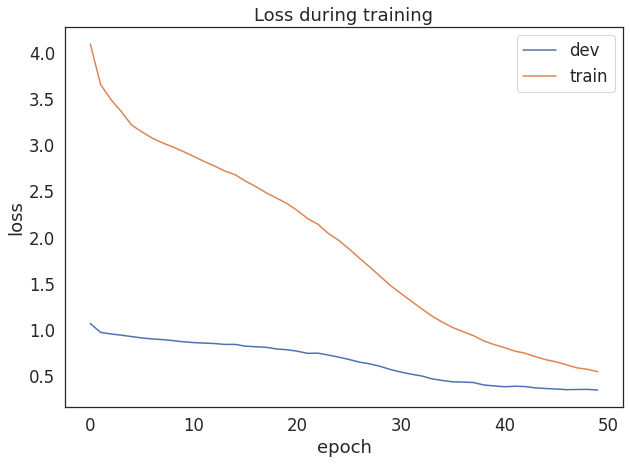

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['loss'], label= 'dev')
plt.plot(coach.train_hist['loss'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Loss during training')

Text(0.5, 1.0, 'f1 score during training')

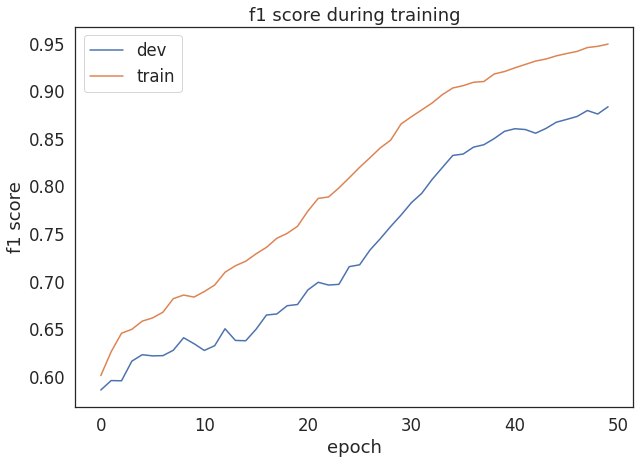

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['f1'], label= 'dev')
plt.plot(coach.train_hist['f1'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1 score")
plt.title('f1 score during training')

Text(0.5, 1.0, 'Accuracy score during training')

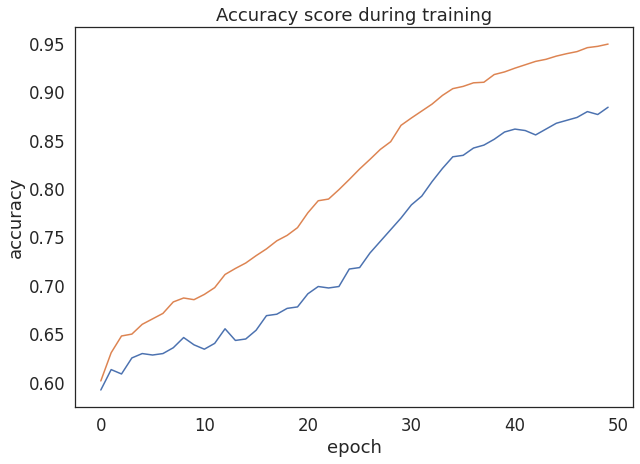

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['acc'], label='dev')
plt.plot(coach.train_hist['acc'], label='train')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('Accuracy score during training')

In [ ]:
coach.evaluate(test=True)

test: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


(0.5735072303112194, 1.370254397392273, 0.5767097966728281)

In [ ]:
model1=coach.model

In [ ]:
dataset = coach.testset 
model1.eval()
with torch.no_grad():
    golds = []
    preds = []
    epoch_loss = 0
    for idx in tqdm(range(len(dataset)), desc="test" if test else "dev"):
        data = dataset[idx]
        golds.append(data["label_tensor"])
        for k, v in data.items():
            data[k] = v.to(args.device)
        y_hat = model1(data)
        nll = model1.get_loss(data)
        epoch_loss += nll.item()
        preds.append(y_hat.detach().to("cpu"))

    golds = torch.cat(golds, dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    

test: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def confusion_matrix(y, y_pred, zero_diag: bool = False): 
  from sklearn.metrics import confusion_matrix

  matrix = confusion_matrix(y, y_pred)
  labels = ['happy','sad', 'neutral', 'angry', 'excited', 'frustrated']

  # Plot
  if zero_diag == True:
      np.fill_diagonal(matrix, 0)

  fig, ax = plt.subplots(figsize = (10,8))
  figure = sns.heatmap(matrix, annot = True, fmt = "d", ax = ax)
  ax.set_xticklabels(labels, rotation = 90, fontsize = 15)
  ax.set_yticklabels(labels, rotation = 0, fontsize = 15)
  ax.set_xlabel("Predicted label", fontsize = 15)
  ax.set_ylabel("True label", fontsize = 15)
  plt.title("Confusion matrix", fontsize = 20)
  plt.show()

  return matrix


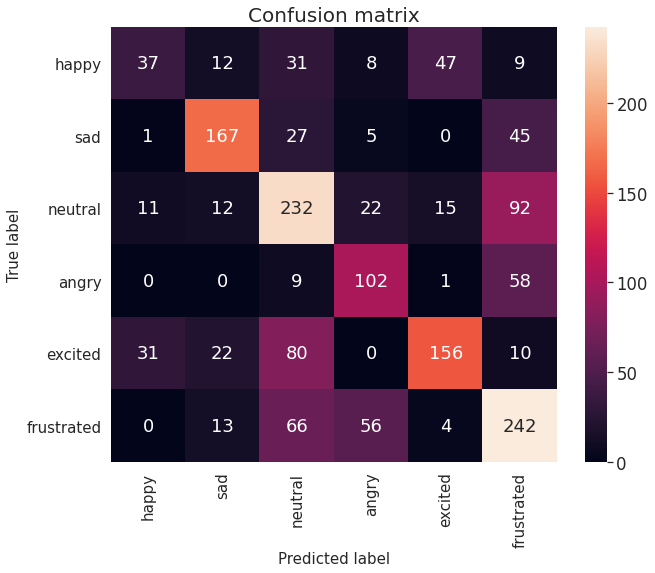

array([[ 37,  12,  31,   8,  47,   9],
       [  1, 167,  27,   5,   0,  45],
       [ 11,  12, 232,  22,  15,  92],
       [  0,   0,   9, 102,   1,  58],
       [ 31,  22,  80,   0, 156,  10],
       [  0,  13,  66,  56,   4, 242]])

In [ ]:
confusion_matrix(golds, preds)

## TRAIN - multimodal (EXP2)

In [ ]:
args = arguments(data='/content/drive/MyDrive/DialogueGCN-mianzhang/data_split.pickle', rnn = 'gru', epochs = 50, drop_rate=0.4, weight_decay=0.0, batch_size = 32, learning_rate = 0.0003, multim=True)

In [ ]:
coach2 = main(args)

08/04/2021 06:05:31 Loaded data.
08/04/2021 06:05:31 Start training...


train epoch 1: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

08/04/2021 06:05:37 
08/04/2021 06:05:37 [Epoch 1] [Loss: 7.064303] [Time: 6.559345]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 06:05:38 [Dev set] [f1 0.5136]
08/04/2021 06:05:38 Save the best model.



train epoch 2: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:05:52 
08/04/2021 06:05:52 [Epoch 2] [Loss: 4.893601] [Time: 6.316459]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

08/04/2021 06:05:53 [Dev set] [f1 0.5838]
08/04/2021 06:05:53 Save the best model.



train epoch 3: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:06:07 
08/04/2021 06:06:07 [Epoch 3] [Loss: 4.433962] [Time: 6.315517]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

08/04/2021 06:06:08 [Dev set] [f1 0.5978]
08/04/2021 06:06:08 Save the best model.



train epoch 4: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 06:06:21 
08/04/2021 06:06:21 [Epoch 4] [Loss: 4.130943] [Time: 6.063957]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 06:06:22 [Dev set] [f1 0.5812]



train epoch 5: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:06:36 
08/04/2021 06:06:36 [Epoch 5] [Loss: 3.949489] [Time: 6.152778]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

08/04/2021 06:06:37 [Dev set] [f1 0.6148]
08/04/2021 06:06:37 Save the best model.



train epoch 6: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:06:51 
08/04/2021 06:06:51 [Epoch 6] [Loss: 3.766356] [Time: 6.353052]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:06:52 [Dev set] [f1 0.6196]
08/04/2021 06:06:52 Save the best model.



train epoch 7: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:07:05 
08/04/2021 06:07:05 [Epoch 7] [Loss: 3.623858] [Time: 6.133289]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

08/04/2021 06:07:06 [Dev set] [f1 0.6093]



train epoch 8: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:07:20 
08/04/2021 06:07:20 [Epoch 8] [Loss: 3.587611] [Time: 6.352291]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

08/04/2021 06:07:21 [Dev set] [f1 0.6222]
08/04/2021 06:07:21 Save the best model.



train epoch 9: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:07:35 
08/04/2021 06:07:35 [Epoch 9] [Loss: 3.512710] [Time: 6.102327]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 06:07:36 [Dev set] [f1 0.6204]



train epoch 10: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:07:49 
08/04/2021 06:07:49 [Epoch 10] [Loss: 3.408648] [Time: 6.313005]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:07:50 [Dev set] [f1 0.6234]
08/04/2021 06:07:50 Save the best model.



train epoch 11: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 06:08:04 
08/04/2021 06:08:04 [Epoch 11] [Loss: 3.324932] [Time: 6.029408]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

08/04/2021 06:08:05 [Dev set] [f1 0.6286]
08/04/2021 06:08:05 Save the best model.



train epoch 12: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:08:18 
08/04/2021 06:08:18 [Epoch 12] [Loss: 3.276881] [Time: 6.315232]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 06:08:19 [Dev set] [f1 0.6292]
08/04/2021 06:08:19 Save the best model.



train epoch 13: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:08:33 
08/04/2021 06:08:33 [Epoch 13] [Loss: 3.210728] [Time: 6.165491]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:08:34 [Dev set] [f1 0.6390]
08/04/2021 06:08:34 Save the best model.



train epoch 14: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

08/04/2021 06:08:48 
08/04/2021 06:08:48 [Epoch 14] [Loss: 3.187116] [Time: 6.270410]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:08:49 [Dev set] [f1 0.6389]



train epoch 15: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:09:02 
08/04/2021 06:09:02 [Epoch 15] [Loss: 3.141691] [Time: 6.172321]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 06:09:03 [Dev set] [f1 0.6378]



train epoch 16: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:09:17 
08/04/2021 06:09:17 [Epoch 16] [Loss: 3.127106] [Time: 6.068264]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

08/04/2021 06:09:18 [Dev set] [f1 0.6528]
08/04/2021 06:09:18 Save the best model.



train epoch 17: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:09:32 
08/04/2021 06:09:32 [Epoch 17] [Loss: 3.064197] [Time: 6.378198]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:09:33 [Dev set] [f1 0.6456]



train epoch 18: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:09:46 
08/04/2021 06:09:46 [Epoch 18] [Loss: 2.970306] [Time: 6.087117]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 06:09:47 [Dev set] [f1 0.6480]



train epoch 19: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:10:01 
08/04/2021 06:10:01 [Epoch 19] [Loss: 2.912062] [Time: 6.331283]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:10:02 [Dev set] [f1 0.6528]



train epoch 20: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:10:16 
08/04/2021 06:10:16 [Epoch 20] [Loss: 2.871484] [Time: 6.140645]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 06:10:17 [Dev set] [f1 0.6503]



train epoch 21: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:10:30 
08/04/2021 06:10:30 [Epoch 21] [Loss: 2.821951] [Time: 6.363676]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 06:10:31 [Dev set] [f1 0.6629]
08/04/2021 06:10:31 Save the best model.



train epoch 22: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:10:45 
08/04/2021 06:10:45 [Epoch 22] [Loss: 2.798191] [Time: 6.093476]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 06:10:46 [Dev set] [f1 0.6574]



train epoch 23: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:11:00 
08/04/2021 06:11:00 [Epoch 23] [Loss: 2.785809] [Time: 6.186661]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 06:11:01 [Dev set] [f1 0.6655]
08/04/2021 06:11:01 Save the best model.



train epoch 24: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]

08/04/2021 06:11:15 
08/04/2021 06:11:15 [Epoch 24] [Loss: 2.710061] [Time: 6.387313]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:11:15 [Dev set] [f1 0.6751]
08/04/2021 06:11:15 Save the best model.



train epoch 25: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:11:29 
08/04/2021 06:11:29 [Epoch 25] [Loss: 2.646293] [Time: 6.153947]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

08/04/2021 06:11:30 [Dev set] [f1 0.6652]



train epoch 26: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:11:44 
08/04/2021 06:11:44 [Epoch 26] [Loss: 2.640562] [Time: 6.342688]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

08/04/2021 06:11:45 [Dev set] [f1 0.6834]
08/04/2021 06:11:45 Save the best model.



train epoch 27: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:11:59 
08/04/2021 06:11:59 [Epoch 27] [Loss: 2.558486] [Time: 6.147445]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 06:12:00 [Dev set] [f1 0.6963]
08/04/2021 06:12:00 Save the best model.



train epoch 28: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]

08/04/2021 06:12:13 
08/04/2021 06:12:13 [Epoch 28] [Loss: 2.522734] [Time: 6.248642]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

08/04/2021 06:12:14 [Dev set] [f1 0.6937]



train epoch 29: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:12:28 
08/04/2021 06:12:28 [Epoch 29] [Loss: 2.459068] [Time: 6.320166]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:12:29 [Dev set] [f1 0.7056]
08/04/2021 06:12:29 Save the best model.



train epoch 30: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:12:43 
08/04/2021 06:12:43 [Epoch 30] [Loss: 2.363862] [Time: 6.163838]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:12:44 [Dev set] [f1 0.7006]



train epoch 31: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:12:57 
08/04/2021 06:12:57 [Epoch 31] [Loss: 2.271950] [Time: 6.358104]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

08/04/2021 06:12:58 [Dev set] [f1 0.7361]
08/04/2021 06:12:58 Save the best model.



train epoch 32: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

08/04/2021 06:13:12 
08/04/2021 06:13:12 [Epoch 32] [Loss: 2.205958] [Time: 6.206566]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:13:13 [Dev set] [f1 0.7346]



train epoch 33: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

08/04/2021 06:13:27 
08/04/2021 06:13:27 [Epoch 33] [Loss: 2.124575] [Time: 6.009418]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

08/04/2021 06:13:28 [Dev set] [f1 0.7385]
08/04/2021 06:13:28 Save the best model.



train epoch 34: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:13:41 
08/04/2021 06:13:41 [Epoch 34] [Loss: 2.037877] [Time: 6.364259]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:13:42 [Dev set] [f1 0.7621]
08/04/2021 06:13:42 Save the best model.



train epoch 35: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 06:13:56 
08/04/2021 06:13:56 [Epoch 35] [Loss: 1.973282] [Time: 6.055267]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

08/04/2021 06:13:57 [Dev set] [f1 0.7892]
08/04/2021 06:13:57 Save the best model.



train epoch 36: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:14:11 
08/04/2021 06:14:11 [Epoch 36] [Loss: 1.859522] [Time: 6.366899]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:14:12 [Dev set] [f1 0.7953]
08/04/2021 06:14:12 Save the best model.



train epoch 37: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 06:14:25 
08/04/2021 06:14:25 [Epoch 37] [Loss: 1.792098] [Time: 6.049978]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:14:26 [Dev set] [f1 0.8005]
08/04/2021 06:14:26 Save the best model.



train epoch 38: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:14:40 
08/04/2021 06:14:40 [Epoch 38] [Loss: 1.677010] [Time: 6.359725]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:14:41 [Dev set] [f1 0.8244]
08/04/2021 06:14:41 Save the best model.



train epoch 39: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:14:55 
08/04/2021 06:14:55 [Epoch 39] [Loss: 1.614273] [Time: 6.082466]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:14:55 [Dev set] [f1 0.8238]



train epoch 40: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

08/04/2021 06:15:09 
08/04/2021 06:15:09 [Epoch 40] [Loss: 1.559165] [Time: 6.223581]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 06:15:10 [Dev set] [f1 0.8296]
08/04/2021 06:15:10 Save the best model.



train epoch 41: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

08/04/2021 06:15:24 
08/04/2021 06:15:24 [Epoch 41] [Loss: 1.452031] [Time: 6.355241]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 06:15:25 [Dev set] [f1 0.8380]
08/04/2021 06:15:25 Save the best model.



train epoch 42: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:15:39 
08/04/2021 06:15:39 [Epoch 42] [Loss: 1.426322] [Time: 6.343080]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 06:15:40 [Dev set] [f1 0.8460]
08/04/2021 06:15:40 Save the best model.



train epoch 43: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

08/04/2021 06:15:53 
08/04/2021 06:15:53 [Epoch 43] [Loss: 1.335010] [Time: 6.281909]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 06:15:54 [Dev set] [f1 0.8505]
08/04/2021 06:15:54 Save the best model.



train epoch 44: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:16:08 
08/04/2021 06:16:08 [Epoch 44] [Loss: 1.290565] [Time: 6.124271]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

08/04/2021 06:16:09 [Dev set] [f1 0.8558]
08/04/2021 06:16:09 Save the best model.



train epoch 45: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

08/04/2021 06:16:23 
08/04/2021 06:16:23 [Epoch 45] [Loss: 1.205749] [Time: 6.485098]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 06:16:24 [Dev set] [f1 0.8584]
08/04/2021 06:16:24 Save the best model.



train epoch 46: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 06:16:37 
08/04/2021 06:16:37 [Epoch 46] [Loss: 1.194803] [Time: 6.076665]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

08/04/2021 06:16:38 [Dev set] [f1 0.8641]
08/04/2021 06:16:38 Save the best model.



train epoch 47: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 06:16:52 
08/04/2021 06:16:52 [Epoch 47] [Loss: 1.153068] [Time: 6.178118]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 06:16:53 [Dev set] [f1 0.8741]
08/04/2021 06:16:53 Save the best model.



train epoch 48: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 06:17:07 
08/04/2021 06:17:07 [Epoch 48] [Loss: 1.064762] [Time: 6.333545]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

08/04/2021 06:17:08 [Dev set] [f1 0.8826]
08/04/2021 06:17:08 Save the best model.



train epoch 49: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:17:22 
08/04/2021 06:17:22 [Epoch 49] [Loss: 1.066765] [Time: 6.143656]



dev: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

08/04/2021 06:17:23 [Dev set] [f1 0.8872]
08/04/2021 06:17:23 Save the best model.



train epoch 50: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 06:17:37 
08/04/2021 06:17:37 [Epoch 50] [Loss: 1.038509] [Time: 6.118724]



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:17:37 [Dev set] [f1 0.8939]
08/04/2021 06:17:37 Save the best model.



dev: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

08/04/2021 06:17:45 
08/04/2021 06:17:45 Best in epoch 50:



dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 06:17:46 [Dev set] [f1 0.8939]



test: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

08/04/2021 06:17:48 [Test set] [f1 0.5898]


Text(0.5, 1.0, 'Loss during training')

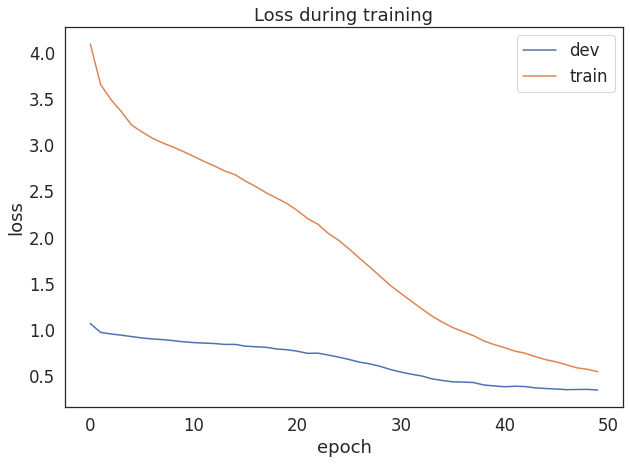

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['loss'], label= 'dev')
plt.plot(coach.train_hist['loss'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Loss during training')

Text(0.5, 1.0, 'f1 score during training')

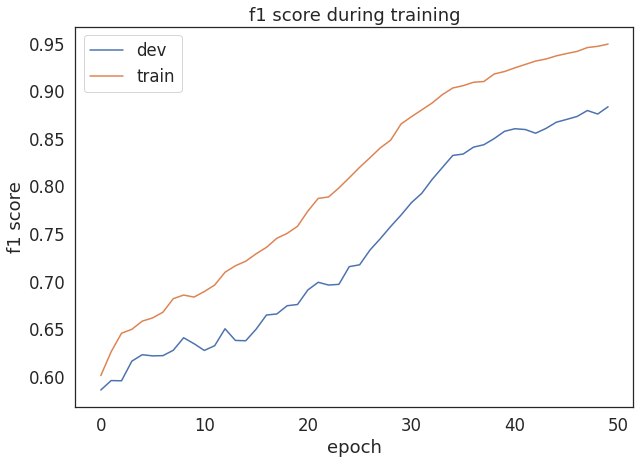

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['f1'], label= 'dev')
plt.plot(coach.train_hist['f1'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1 score")
plt.title('f1 score during training')

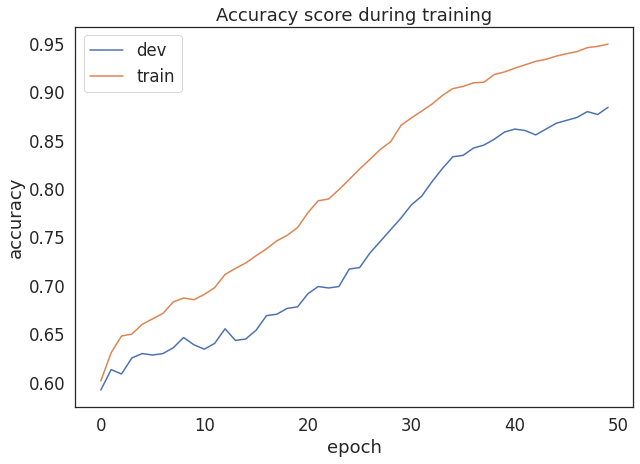

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['acc'], label='dev')
plt.plot(coach.train_hist['acc'], label='train')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('Accuracy score during training')
plt.legend()

In [ ]:
coach2.evaluate(test=True)

test: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


(0.5897826604939213, 1.294546365737915, 0.5884165126309304)

In [ ]:
model2=coach2.model

In [ ]:
dataset = coach2.testset 
model2.eval()
with torch.no_grad():
    golds = []
    preds = []
    epoch_loss = 0
    for idx in tqdm(range(len(dataset)), desc="test" if test else "dev"):
        data = dataset[idx]
        golds.append(data["label_tensor"])
        for k, v in data.items():
            data[k] = v.to(args.device)
        y_hat = model2(data)
        nll = model2.get_loss(data)
        epoch_loss += nll.item()
        preds.append(y_hat.detach().to("cpu"))

    golds = torch.cat(golds, dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()

test: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


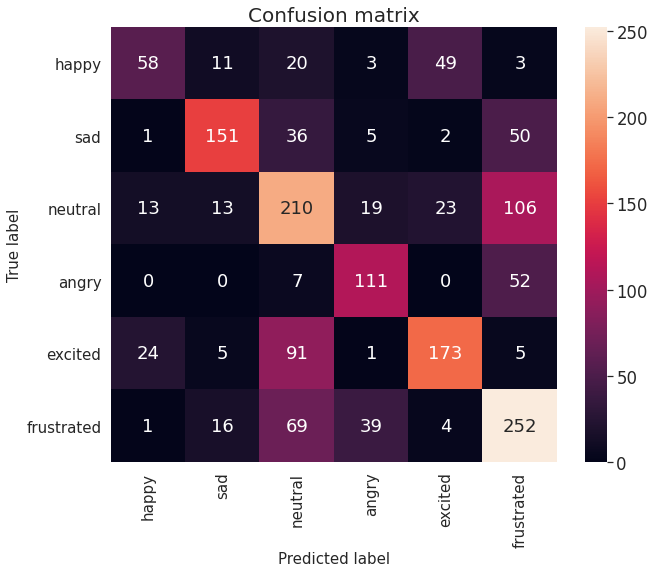

array([[ 58,  11,  20,   3,  49,   3],
       [  1, 151,  36,   5,   2,  50],
       [ 13,  13, 210,  19,  23, 106],
       [  0,   0,   7, 111,   0,  52],
       [ 24,   5,  91,   1, 173,   5],
       [  1,  16,  69,  39,   4, 252]])

In [ ]:
confusion_matrix(golds, preds)

## TRAIN - multimodal (EXP1)

In [ ]:
args = arguments(data='/content/drive/MyDrive/DialogueGCN-mianzhang/data_split.pickle', rnn = 'gru', epochs = 50, drop_rate=0.4, weight_decay=0.0, batch_size = 32, learning_rate = 0.0003, multim=False, exp1=True)

In [ ]:
coach3 = main(args)

08/04/2021 09:04:14 Loaded data.
08/04/2021 09:04:14 Start training...




















train epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


















train epoch 1:  25%|██▌       | 1/4 [00:02<00:06,  2.14s/it]

















train epoch 1:  50%|█████     | 2/4 [00:03<00:04,  2.01s/it]

















train epoch 1:  75%|███████▌  | 3/4 [00:05<00:01,  1.84s/it]

















train epoch 1: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 09:04:20 
08/04/2021 09:04:20 [Epoch 1] [Loss: 6.400607] [Time: 5.958108]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

08/04/2021 09:04:21 [Dev set] [f1 0.4870]
08/04/2021 09:04:21 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.16s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.11s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


















train epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 2:  25%|██▌       | 1/4 [00:01<00:05,  1.87s/it]

















train epoch 2:  50%|█████     | 2/4 [00:03<00:03,  1.83s/it]

















train epoch 2:  75%|███████▌  | 3/4 [00:05<00:01,  1.79s/it]

















train epoch 2: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]

08/04/2021 09:04:34 
08/04/2021 09:04:34 [Epoch 2] [Loss: 4.405167] [Time: 5.952592]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 09:04:34 [Dev set] [f1 0.5833]
08/04/2021 09:04:34 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


















train epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 3:  25%|██▌       | 1/4 [00:01<00:04,  1.61s/it]

















train epoch 3:  50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

















train epoch 3:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 3: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:04:48 
08/04/2021 09:04:48 [Epoch 3] [Loss: 4.023649] [Time: 5.812760]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

08/04/2021 09:04:49 [Dev set] [f1 0.5766]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.21s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


















train epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 4:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 4:  50%|█████     | 2/4 [00:03<00:03,  1.77s/it]

















train epoch 4:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 4: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:05:02 
08/04/2021 09:05:02 [Epoch 4] [Loss: 3.844890] [Time: 5.817558]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 09:05:02 [Dev set] [f1 0.6229]
08/04/2021 09:05:02 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 5:  25%|██▌       | 1/4 [00:01<00:04,  1.62s/it]

















train epoch 5:  50%|█████     | 2/4 [00:03<00:03,  1.74s/it]

















train epoch 5:  75%|███████▌  | 3/4 [00:05<00:01,  1.65s/it]

















train epoch 5: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 09:05:15 
08/04/2021 09:05:15 [Epoch 5] [Loss: 3.624497] [Time: 5.726909]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

08/04/2021 09:05:16 [Dev set] [f1 0.6320]
08/04/2021 09:05:16 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


















train epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 6:  25%|██▌       | 1/4 [00:01<00:04,  1.62s/it]

















train epoch 6:  50%|█████     | 2/4 [00:03<00:03,  1.74s/it]

















train epoch 6:  75%|███████▌  | 3/4 [00:05<00:01,  1.65s/it]

















train epoch 6: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 09:05:29 
08/04/2021 09:05:29 [Epoch 6] [Loss: 3.542081] [Time: 5.773685]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

08/04/2021 09:05:30 [Dev set] [f1 0.6064]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 7:  25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

















train epoch 7:  50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

















train epoch 7:  75%|███████▌  | 3/4 [00:05<00:01,  1.73s/it]

















train epoch 7: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 09:05:43 
08/04/2021 09:05:43 [Epoch 7] [Loss: 3.404542] [Time: 5.770872]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

08/04/2021 09:05:44 [Dev set] [f1 0.6438]
08/04/2021 09:05:44 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.08s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.05s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


















train epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 8:  25%|██▌       | 1/4 [00:01<00:05,  1.87s/it]

















train epoch 8:  50%|█████     | 2/4 [00:03<00:03,  1.84s/it]

















train epoch 8:  75%|███████▌  | 3/4 [00:05<00:01,  1.73s/it]

















train epoch 8: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]

08/04/2021 09:05:57 
08/04/2021 09:05:57 [Epoch 8] [Loss: 3.323661] [Time: 5.995050]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:05:58 [Dev set] [f1 0.6498]
08/04/2021 09:05:58 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.07s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


















train epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 9:  25%|██▌       | 1/4 [00:02<00:06,  2.06s/it]

















train epoch 9:  50%|█████     | 2/4 [00:03<00:03,  1.97s/it]

















train epoch 9:  75%|███████▌  | 3/4 [00:05<00:01,  1.90s/it]

















train epoch 9: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

08/04/2021 09:06:11 
08/04/2021 09:06:11 [Epoch 9] [Loss: 3.255844] [Time: 6.217679]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

08/04/2021 09:06:12 [Dev set] [f1 0.6478]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.29s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


















train epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 10:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 10:  50%|█████     | 2/4 [00:03<00:03,  1.70s/it]

















train epoch 10:  75%|███████▌  | 3/4 [00:05<00:01,  1.70s/it]

















train epoch 10: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 09:06:26 
08/04/2021 09:06:26 [Epoch 10] [Loss: 3.199060] [Time: 5.863314]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 09:06:27 [Dev set] [f1 0.6648]
08/04/2021 09:06:27 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.29s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.29s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.23s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


















train epoch 11:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 11:  25%|██▌       | 1/4 [00:01<00:04,  1.62s/it]

















train epoch 11:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

















train epoch 11:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 11: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 09:06:40 
08/04/2021 09:06:40 [Epoch 11] [Loss: 3.128255] [Time: 5.859165]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

08/04/2021 09:06:41 [Dev set] [f1 0.6647]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


















train epoch 12:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 12:  25%|██▌       | 1/4 [00:01<00:04,  1.66s/it]

















train epoch 12:  50%|█████     | 2/4 [00:03<00:03,  1.77s/it]

















train epoch 12:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 12: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 09:06:54 
08/04/2021 09:06:54 [Epoch 12] [Loss: 3.022128] [Time: 5.839136]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 09:06:55 [Dev set] [f1 0.6624]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 13:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 13:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 13:  50%|█████     | 2/4 [00:03<00:03,  1.74s/it]

















train epoch 13:  75%|███████▌  | 3/4 [00:05<00:01,  1.66s/it]

















train epoch 13: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:07:08 
08/04/2021 09:07:08 [Epoch 13] [Loss: 2.991861] [Time: 5.810301]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 09:07:09 [Dev set] [f1 0.6730]
08/04/2021 09:07:09 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.33s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.32s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.21s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


















train epoch 14:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 14:  25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]

















train epoch 14:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

















train epoch 14:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 14: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 09:07:22 
08/04/2021 09:07:22 [Epoch 14] [Loss: 2.913063] [Time: 5.791982]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

08/04/2021 09:07:23 [Dev set] [f1 0.6745]
08/04/2021 09:07:23 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.02s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


















train epoch 15:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 15:  25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]

















train epoch 15:  50%|█████     | 2/4 [00:03<00:03,  1.88s/it]

















train epoch 15:  75%|███████▌  | 3/4 [00:05<00:01,  1.83s/it]

















train epoch 15: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 09:07:36 
08/04/2021 09:07:36 [Epoch 15] [Loss: 2.827663] [Time: 6.105631]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 09:07:37 [Dev set] [f1 0.6786]
08/04/2021 09:07:37 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.20s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


















train epoch 16:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 16:  25%|██▌       | 1/4 [00:01<00:05,  1.91s/it]

















train epoch 16:  50%|█████     | 2/4 [00:03<00:03,  1.87s/it]

















train epoch 16:  75%|███████▌  | 3/4 [00:05<00:01,  1.84s/it]

















train epoch 16: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 09:07:50 
08/04/2021 09:07:50 [Epoch 16] [Loss: 2.778857] [Time: 6.128248]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:07:51 [Dev set] [f1 0.6973]
08/04/2021 09:07:51 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


















train epoch 17:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 17:  25%|██▌       | 1/4 [00:01<00:05,  1.88s/it]

















train epoch 17:  50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

















train epoch 17:  75%|███████▌  | 3/4 [00:05<00:01,  1.82s/it]

















train epoch 17: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 09:08:04 
08/04/2021 09:08:04 [Epoch 17] [Loss: 2.712292] [Time: 6.078937]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

08/04/2021 09:08:05 [Dev set] [f1 0.7048]
08/04/2021 09:08:05 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


















train epoch 18:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 18:  25%|██▌       | 1/4 [00:01<00:04,  1.64s/it]

















train epoch 18:  50%|█████     | 2/4 [00:03<00:03,  1.67s/it]

















train epoch 18:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 18: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

08/04/2021 09:08:18 
08/04/2021 09:08:18 [Epoch 18] [Loss: 2.606722] [Time: 5.729981]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 09:08:19 [Dev set] [f1 0.7109]
08/04/2021 09:08:19 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


















train epoch 19:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 19:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 19:  50%|█████     | 2/4 [00:03<00:03,  1.68s/it]

















train epoch 19:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 19: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:08:32 
08/04/2021 09:08:32 [Epoch 19] [Loss: 2.522344] [Time: 5.803457]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

08/04/2021 09:08:33 [Dev set] [f1 0.7196]
08/04/2021 09:08:33 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


















train epoch 20:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 20:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 20:  50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

















train epoch 20:  75%|███████▌  | 3/4 [00:05<00:01,  1.65s/it]

















train epoch 20: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

08/04/2021 09:08:46 
08/04/2021 09:08:46 [Epoch 20] [Loss: 2.429276] [Time: 5.755410]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

08/04/2021 09:08:47 [Dev set] [f1 0.7414]
08/04/2021 09:08:47 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


















train epoch 21:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 21:  25%|██▌       | 1/4 [00:01<00:04,  1.62s/it]

















train epoch 21:  50%|█████     | 2/4 [00:03<00:03,  1.74s/it]

















train epoch 21:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 21: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:09:00 
08/04/2021 09:09:00 [Epoch 21] [Loss: 2.336585] [Time: 5.829362]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

08/04/2021 09:09:01 [Dev set] [f1 0.7464]
08/04/2021 09:09:01 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.96s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.03s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


















train epoch 22:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 22:  25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]

















train epoch 22:  50%|█████     | 2/4 [00:03<00:03,  1.86s/it]

















train epoch 22:  75%|███████▌  | 3/4 [00:05<00:01,  1.78s/it]

















train epoch 22: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]

08/04/2021 09:09:14 
08/04/2021 09:09:14 [Epoch 22] [Loss: 2.210236] [Time: 5.997734]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

08/04/2021 09:09:16 [Dev set] [f1 0.7455]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.03s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


















train epoch 23:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 23:  25%|██▌       | 1/4 [00:01<00:05,  1.87s/it]

















train epoch 23:  50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

















train epoch 23:  75%|███████▌  | 3/4 [00:05<00:01,  1.76s/it]

















train epoch 23: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 09:09:29 
08/04/2021 09:09:29 [Epoch 23] [Loss: 2.116233] [Time: 6.118124]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:09:30 [Dev set] [f1 0.7695]
08/04/2021 09:09:30 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.32s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


















train epoch 24:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 24:  25%|██▌       | 1/4 [00:01<00:05,  1.87s/it]

















train epoch 24:  50%|█████     | 2/4 [00:03<00:03,  1.84s/it]

















train epoch 24:  75%|███████▌  | 3/4 [00:05<00:01,  1.81s/it]

















train epoch 24: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 09:09:43 
08/04/2021 09:09:43 [Epoch 24] [Loss: 2.001971] [Time: 6.061011]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

08/04/2021 09:09:44 [Dev set] [f1 0.7718]
08/04/2021 09:09:44 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


















train epoch 25:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 25:  25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]

















train epoch 25:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

















train epoch 25:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 25: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:09:57 
08/04/2021 09:09:57 [Epoch 25] [Loss: 1.889416] [Time: 5.821195]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:09:58 [Dev set] [f1 0.7804]
08/04/2021 09:09:58 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


















train epoch 26:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 26:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 26:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

















train epoch 26:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 26: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

08/04/2021 09:10:11 
08/04/2021 09:10:11 [Epoch 26] [Loss: 1.822618] [Time: 5.888829]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:10:12 [Dev set] [f1 0.7999]
08/04/2021 09:10:12 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 27:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 27:  25%|██▌       | 1/4 [00:01<00:04,  1.62s/it]

















train epoch 27:  50%|█████     | 2/4 [00:03<00:03,  1.73s/it]

















train epoch 27:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 27: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:10:25 
08/04/2021 09:10:25 [Epoch 27] [Loss: 1.701251] [Time: 5.815282]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:10:26 [Dev set] [f1 0.8040]
08/04/2021 09:10:26 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


















train epoch 28:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 28:  25%|██▌       | 1/4 [00:01<00:05,  1.70s/it]

















train epoch 28:  50%|█████     | 2/4 [00:03<00:03,  1.81s/it]

















train epoch 28:  75%|███████▌  | 3/4 [00:05<00:01,  1.72s/it]

















train epoch 28: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 09:10:39 
08/04/2021 09:10:39 [Epoch 28] [Loss: 1.632068] [Time: 5.934270]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

08/04/2021 09:10:40 [Dev set] [f1 0.8118]
08/04/2021 09:10:40 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.96s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.11s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.11s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 29:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 29:  25%|██▌       | 1/4 [00:01<00:05,  1.91s/it]

















train epoch 29:  50%|█████     | 2/4 [00:03<00:03,  1.88s/it]

















train epoch 29:  75%|███████▌  | 3/4 [00:05<00:01,  1.76s/it]

















train epoch 29: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

08/04/2021 09:10:54 
08/04/2021 09:10:54 [Epoch 29] [Loss: 1.504991] [Time: 5.889107]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 09:10:55 [Dev set] [f1 0.8292]
08/04/2021 09:10:55 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.18s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


















train epoch 30:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 30:  25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

















train epoch 30:  50%|█████     | 2/4 [00:03<00:03,  1.86s/it]

















train epoch 30:  75%|███████▌  | 3/4 [00:05<00:01,  1.87s/it]

















train epoch 30: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]

08/04/2021 09:11:08 
08/04/2021 09:11:08 [Epoch 30] [Loss: 1.387976] [Time: 6.249853]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:11:09 [Dev set] [f1 0.8341]
08/04/2021 09:11:09 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


















train epoch 31:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 31:  25%|██▌       | 1/4 [00:01<00:05,  1.98s/it]

















train epoch 31:  50%|█████     | 2/4 [00:03<00:03,  1.92s/it]

















train epoch 31:  75%|███████▌  | 3/4 [00:05<00:01,  1.87s/it]

















train epoch 31: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 09:11:22 
08/04/2021 09:11:22 [Epoch 31] [Loss: 1.329583] [Time: 6.170768]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

08/04/2021 09:11:23 [Dev set] [f1 0.8356]
08/04/2021 09:11:23 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


















train epoch 32:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 32:  25%|██▌       | 1/4 [00:01<00:04,  1.64s/it]

















train epoch 32:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

















train epoch 32:  75%|███████▌  | 3/4 [00:05<00:01,  1.69s/it]

















train epoch 32: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 09:11:36 
08/04/2021 09:11:36 [Epoch 32] [Loss: 1.260828] [Time: 5.849033]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

08/04/2021 09:11:38 [Dev set] [f1 0.8471]
08/04/2021 09:11:38 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.18s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


















train epoch 33:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 33:  25%|██▌       | 1/4 [00:01<00:04,  1.66s/it]

















train epoch 33:  50%|█████     | 2/4 [00:03<00:03,  1.82s/it]

















train epoch 33:  75%|███████▌  | 3/4 [00:05<00:01,  1.72s/it]

















train epoch 33: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

08/04/2021 09:11:51 
08/04/2021 09:11:51 [Epoch 33] [Loss: 1.229565] [Time: 6.045943]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

08/04/2021 09:11:52 [Dev set] [f1 0.8555]
08/04/2021 09:11:52 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.18s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 34:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 34:  25%|██▌       | 1/4 [00:01<00:05,  1.68s/it]

















train epoch 34:  50%|█████     | 2/4 [00:03<00:03,  1.80s/it]

















train epoch 34:  75%|███████▌  | 3/4 [00:05<00:01,  1.70s/it]

















train epoch 34: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 09:12:05 
08/04/2021 09:12:05 [Epoch 34] [Loss: 1.157988] [Time: 5.930667]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

08/04/2021 09:12:06 [Dev set] [f1 0.8550]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.19s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


















train epoch 35:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 35:  25%|██▌       | 1/4 [00:02<00:06,  2.00s/it]

















train epoch 35:  50%|█████     | 2/4 [00:04<00:04,  2.01s/it]

















train epoch 35:  75%|███████▌  | 3/4 [00:05<00:01,  1.93s/it]

















train epoch 35: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]

08/04/2021 09:12:20 
08/04/2021 09:12:20 [Epoch 35] [Loss: 1.135043] [Time: 6.446565]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:12:21 [Dev set] [f1 0.8543]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.16s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.11s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


















train epoch 36:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 36:  25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

















train epoch 36:  50%|█████     | 2/4 [00:03<00:03,  1.90s/it]

















train epoch 36:  75%|███████▌  | 3/4 [00:05<00:01,  1.85s/it]

















train epoch 36: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 09:12:34 
08/04/2021 09:12:34 [Epoch 36] [Loss: 1.086088] [Time: 6.133860]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

08/04/2021 09:12:35 [Dev set] [f1 0.8788]
08/04/2021 09:12:35 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


















train epoch 37:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 37:  25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

















train epoch 37:  50%|█████     | 2/4 [00:03<00:03,  1.86s/it]

















train epoch 37:  75%|███████▌  | 3/4 [00:05<00:01,  1.82s/it]

















train epoch 37: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

08/04/2021 09:12:48 
08/04/2021 09:12:48 [Epoch 37] [Loss: 1.056080] [Time: 6.117896]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:12:49 [Dev set] [f1 0.8708]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.11s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


















train epoch 38:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 38:  25%|██▌       | 1/4 [00:01<00:05,  1.67s/it]

















train epoch 38:  50%|█████     | 2/4 [00:03<00:03,  1.80s/it]

















train epoch 38:  75%|███████▌  | 3/4 [00:05<00:01,  1.71s/it]

















train epoch 38: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]

08/04/2021 09:13:02 
08/04/2021 09:13:02 [Epoch 38] [Loss: 0.984450] [Time: 5.954562]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 09:13:03 [Dev set] [f1 0.8739]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.19s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


















train epoch 39:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 39:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 39:  50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

















train epoch 39:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 39: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

08/04/2021 09:13:16 
08/04/2021 09:13:16 [Epoch 39] [Loss: 0.954763] [Time: 5.836654]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:13:17 [Dev set] [f1 0.8849]
08/04/2021 09:13:17 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


















train epoch 40:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 40:  25%|██▌       | 1/4 [00:01<00:04,  1.64s/it]

















train epoch 40:  50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

















train epoch 40:  75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

















train epoch 40: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:13:30 
08/04/2021 09:13:30 [Epoch 40] [Loss: 0.897351] [Time: 5.802637]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 09:13:31 [Dev set] [f1 0.8707]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 41:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 41:  25%|██▌       | 1/4 [00:01<00:05,  1.76s/it]

















train epoch 41:  50%|█████     | 2/4 [00:03<00:03,  1.84s/it]

















train epoch 41:  75%|███████▌  | 3/4 [00:05<00:01,  1.73s/it]

















train epoch 41: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 09:13:44 
08/04/2021 09:13:44 [Epoch 41] [Loss: 0.877541] [Time: 5.924184]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

08/04/2021 09:13:46 [Dev set] [f1 0.8850]
08/04/2021 09:13:46 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.05s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.03s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


















train epoch 42:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 42:  25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

















train epoch 42:  50%|█████     | 2/4 [00:03<00:03,  1.89s/it]

















train epoch 42:  75%|███████▌  | 3/4 [00:05<00:01,  1.76s/it]

















train epoch 42: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

08/04/2021 09:13:59 
08/04/2021 09:13:59 [Epoch 42] [Loss: 0.851398] [Time: 6.106388]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

08/04/2021 09:14:00 [Dev set] [f1 0.8909]
08/04/2021 09:14:00 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


















train epoch 43:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 43:  25%|██▌       | 1/4 [00:01<00:05,  1.91s/it]

















train epoch 43:  50%|█████     | 2/4 [00:03<00:03,  1.90s/it]

















train epoch 43:  75%|███████▌  | 3/4 [00:05<00:01,  1.90s/it]

















train epoch 43: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

08/04/2021 09:14:13 
08/04/2021 09:14:13 [Epoch 43] [Loss: 0.845717] [Time: 6.348196]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:14:14 [Dev set] [f1 0.8803]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:07,  2.35s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.33s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


















train epoch 44:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 44:  25%|██▌       | 1/4 [00:01<00:05,  1.67s/it]

















train epoch 44:  50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

















train epoch 44:  75%|███████▌  | 3/4 [00:05<00:01,  1.74s/it]

















train epoch 44: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]

08/04/2021 09:14:27 
08/04/2021 09:14:27 [Epoch 44] [Loss: 0.789901] [Time: 6.003395]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

08/04/2021 09:14:28 [Dev set] [f1 0.8893]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.10s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 45:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 45:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

















train epoch 45:  50%|█████     | 2/4 [00:03<00:03,  1.68s/it]

















train epoch 45:  75%|███████▌  | 3/4 [00:05<00:01,  1.69s/it]

















train epoch 45: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:14:41 
08/04/2021 09:14:41 [Epoch 45] [Loss: 0.773479] [Time: 5.818884]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:14:42 [Dev set] [f1 0.8976]
08/04/2021 09:14:42 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


















train epoch 46:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 46:  25%|██▌       | 1/4 [00:01<00:04,  1.66s/it]

















train epoch 46:  50%|█████     | 2/4 [00:03<00:03,  1.77s/it]

















train epoch 46:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

















train epoch 46: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

08/04/2021 09:14:55 
08/04/2021 09:14:55 [Epoch 46] [Loss: 0.745736] [Time: 5.805550]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 09:14:56 [Dev set] [f1 0.9008]
08/04/2021 09:14:56 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.19s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


















train epoch 47:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 47:  25%|██▌       | 1/4 [00:01<00:05,  1.70s/it]

















train epoch 47:  50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

















train epoch 47:  75%|███████▌  | 3/4 [00:05<00:01,  1.70s/it]

















train epoch 47: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

08/04/2021 09:15:09 
08/04/2021 09:15:09 [Epoch 47] [Loss: 0.733038] [Time: 5.873855]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

08/04/2021 09:15:10 [Dev set] [f1 0.8959]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.07s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.04s/it]

















dev: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


















train epoch 48:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 48:  25%|██▌       | 1/4 [00:01<00:05,  1.90s/it]

















train epoch 48:  50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

















train epoch 48:  75%|███████▌  | 3/4 [00:05<00:01,  1.74s/it]

















train epoch 48: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

08/04/2021 09:15:23 
08/04/2021 09:15:23 [Epoch 48] [Loss: 0.653474] [Time: 6.039050]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

08/04/2021 09:15:24 [Dev set] [f1 0.8976]





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.18s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.09s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


















train epoch 49:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 49:  25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

















train epoch 49:  50%|█████     | 2/4 [00:03<00:03,  1.90s/it]

















train epoch 49:  75%|███████▌  | 3/4 [00:05<00:01,  1.85s/it]

















train epoch 49: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

08/04/2021 09:15:38 
08/04/2021 09:15:38 [Epoch 49] [Loss: 0.645749] [Time: 6.188705]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

08/04/2021 09:15:39 [Dev set] [f1 0.9039]
08/04/2021 09:15:39 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.15s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


















train epoch 50:   0%|          | 0/4 [00:00<?, ?it/s]

















train epoch 50:  25%|██▌       | 1/4 [00:01<00:04,  1.64s/it]

















train epoch 50:  50%|█████     | 2/4 [00:03<00:03,  1.70s/it]

















train epoch 50:  75%|███████▌  | 3/4 [00:05<00:01,  1.72s/it]

















train epoch 50: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

08/04/2021 09:15:52 
08/04/2021 09:15:52 [Epoch 50] [Loss: 0.611102] [Time: 5.934286]





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

08/04/2021 09:15:53 [Dev set] [f1 0.9066]
08/04/2021 09:15:53 Save the best model.





















dev:   0%|          | 0/4 [00:00<?, ?it/s]

















dev:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

















dev:  50%|█████     | 2/4 [00:04<00:04,  2.20s/it]

















dev:  75%|███████▌  | 3/4 [00:06<00:02,  2.06s/it]

















dev: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

08/04/2021 09:16:00 
08/04/2021 09:16:00 Best in epoch 50:





















dev:   0%|          | 0/1 [00:00<?, ?it/s]

















dev: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

08/04/2021 09:16:01 [Dev set] [f1 0.9066]





















test:   0%|          | 0/1 [00:00<?, ?it/s]

















test: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

08/04/2021 09:16:03 [Test set] [f1 0.5851]


Text(0.5, 1.0, 'Loss during training')

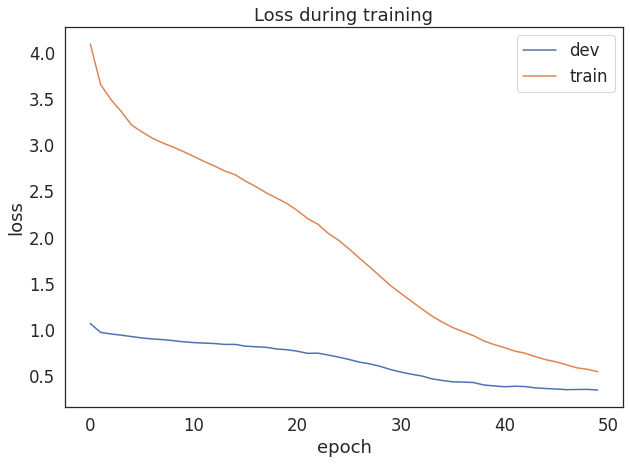

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['loss'], label= 'dev')
plt.plot(coach.train_hist['loss'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Loss during training')

Text(0.5, 1.0, 'f1 score during training')

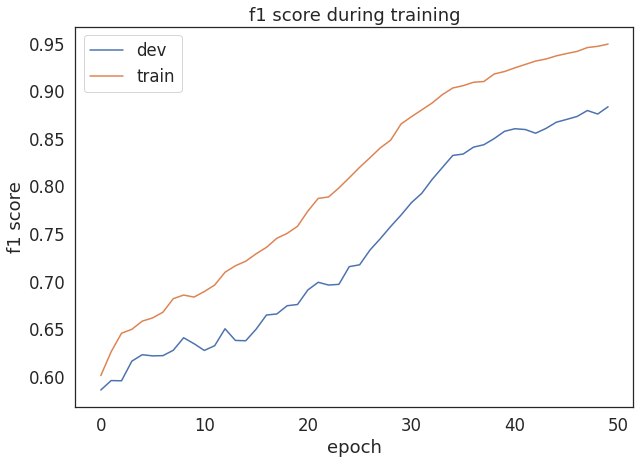

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['f1'], label= 'dev')
plt.plot(coach.train_hist['f1'], label = 'train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1 score")
plt.title('f1 score during training')

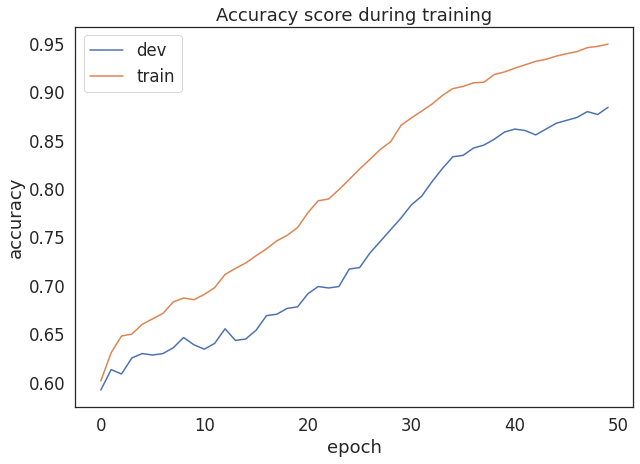

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(coach.dev_hist['acc'], label='dev')
plt.plot(coach.train_hist['acc'], label='train')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('Accuracy score during training')
plt.legend()

In [ ]:
model3 = coach3.model

In [ ]:
dataset = coach3.testset 
model3.eval()
with torch.no_grad():
    golds = []
    preds = []
    epoch_loss = 0
    for idx in tqdm(range(len(dataset)), desc="test" if test else "dev"):
        data = dataset[idx]
        golds.append(data["label_tensor"])
        for k, v in data.items():
            data[k] = v.to(args.device)
        y_hat = model3(data)
        nll = model3.get_loss(data)
        epoch_loss += nll.item()
        preds.append(y_hat.detach().to("cpu"))

    golds = torch.cat(golds, dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()



















test:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


















test: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


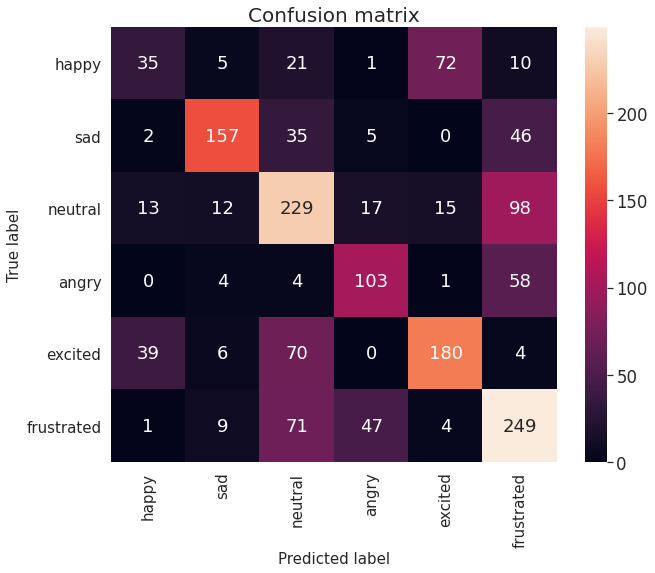

array([[ 35,   5,  21,   1,  72,  10],
       [  2, 157,  35,   5,   0,  46],
       [ 13,  12, 229,  17,  15,  98],
       [  0,   4,   4, 103,   1,  58],
       [ 39,   6,  70,   0, 180,   4],
       [  1,   9,  71,  47,   4, 249]])

In [ ]:
confusion_matrix(golds, preds)

In [ ]:
coach3.evaluate(test=True)



















test:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


















test: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


(0.5851277049840108, 1.4986265897750854, 0.5871842267406038)

In [ ]:
np.array(coach3.dev_hist['acc']) - np.array(coach3.dev_hist['f1'])

array([ 5.21764534e-02,  1.90640624e-02,  2.42904601e-02,  8.10840453e-03,
        2.01553521e-03,  1.10728009e-02,  2.28188944e-03,  6.84056120e-03,
        8.84436311e-03,  6.86887161e-03,  8.53967126e-03,  1.22509725e-02,
        1.07082135e-02,  1.07631480e-02,  8.11278693e-03,  4.49941243e-03,
        6.00232732e-03,  5.97461616e-03,  4.82360110e-03,  2.53757337e-03,
        5.14265960e-03,  9.00284189e-03,  3.06243644e-03,  3.77932924e-03,
        5.70749330e-03,  2.78119046e-03,  3.24177480e-03,  4.46204614e-03,
        3.58774466e-03,  3.24296911e-03,  3.24030086e-03,  2.30779080e-03,
        1.40410988e-03,  1.90847633e-03,  4.12922600e-03,  7.66028051e-04,
        1.14012805e-03,  1.05080850e-03,  6.88809714e-04,  1.29044463e-03,
        5.80456337e-04,  6.32485999e-04,  7.56467961e-04,  8.03811773e-04,
       -1.76519993e-06, -2.18324602e-04,  1.50205880e-04, -1.32398357e-05,
       -3.34611529e-04, -1.74613890e-05])